In [1]:
%tensorflow_version 1.x

import tensorflow as tf 
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


TensorFlow 1.x selected.
11493376/11490434 [==============================] - 0s 0us/step


In [0]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

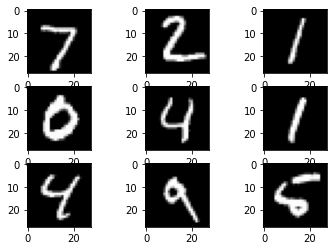

In [3]:
from matplotlib import pyplot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_test[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [0]:
import cv2


for i in range (0,10000):
  X_test[i] = cv2.blur(X_test[i],(7,7))  

  

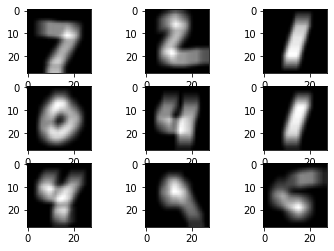

In [5]:
from matplotlib import pyplot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_test[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [7]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

Using TensorFlow backend.


In [0]:
import numpy as np

X_train1 = np.ndarray(shape = (51000, 28,28,3), dtype = 'float32')
X_val1 =   np.ndarray(shape = (9000, 28,28,3), dtype = 'float32')
X_test1 = np.ndarray(shape = (10000,28,28,3), dtype = 'float32')

In [0]:
import cv2


for i in range(0,51000):
    X_train1[i] = cv2.cvtColor(X_train[i],cv2.COLOR_GRAY2BGR)
    
for i in range(0,9000):
    X_val1[i] = cv2.cvtColor(X_val[i],cv2.COLOR_GRAY2BGR)    
    
    
for i in range(0,10000):
    X_test1[i] = cv2.cvtColor(X_test[i],cv2.COLOR_GRAY2RGB)    

In [0]:
train_f = np.ndarray(shape = (51000,48,48,3), dtype = 'float32')
val_f = np.ndarray(shape = (9000,48,48,3) , dtype = 'float32')
test_f = np.ndarray(shape = (10000,48,48,3) , dtype = 'float32')

In [0]:
for i in range(0,51000):
     train_f[i] = cv2.resize(X_train1[i],(48,48))
        
for i in range(0,9000):
      val_f[i] = cv2.resize(X_val1[i],(48,48))  
      
for i in range(0,10000):
     test_f[i] = cv2.resize(X_test1[i],(48,48))    


In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [0]:
for layer in base_model.layers:
     layer.trainable = True

In [15]:

from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.engine import Model


# Extract the last layer from third block of vgg16 model
last = base_model.output


# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)



In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:

X_train = train_f
X_val =   val_f
X_test =  test_f

In [19]:
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)


(10000, 48, 48, 3)
(51000, 48, 48, 3)
(9000, 48, 48, 3)


In [20]:
print(Y_test.shape)
print(Y_train.shape)
print(Y_val.shape)

(10000, 10)
(51000, 10)
(9000, 10)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [0]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [0]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [24]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
1593/1593 [==============================] - 147s 92ms/step - loss: 0.0824 - accuracy: 0.9727 - val_loss: 0.0383 - val_accuracy: 0.9853
Epoch 2/40
1593/1593 [==============================] - 135s 85ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.0256 - val_accuracy: 0.9961
Epoch 3/40
1593/1593 [==============================] - 136s 85ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0039 - val_accuracy: 0.9969
Epoch 4/40
1593/1593 [==============================] - 132s 83ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0098 - val_accuracy: 0.9971
Epoch 5/40
1593/1593 [==============================] - 134s 84ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 8.4743e-05 - val_accuracy: 0.9977
Epoch 6/40
1593/1593 [==============================] - 135s 84ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.0013 - val_accuracy: 0.9963
Epoch 7/40
1593/159

In [25]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4116303779125214
Test accuracy: 0.8786197304725647


In [0]:
predictions = model.predict(X_test/255.)

In [0]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#pred = np.round(model.predict(x_test),0)

labels = ['zero' , 'one' , 'two' , 'three' , 'four' , 'five', 'six' , 'seven' , 'eight' , 'nine']
#labels = ['0','1','2','3','4','5','6','7','8','9']

classification_result = metrics.classification_report(y_test , predictions , target_names=labels)
print(classification_result)

              precision    recall  f1-score   support

        zero       1.00      0.13      0.22       980
         one       0.12      1.00      0.21      1135
         two       0.00      0.00      0.00      1032
       three       0.00      0.00      0.00      1010
        four       0.00      0.00      0.00       982
        five       0.97      0.04      0.07       892
         six       0.00      0.00      0.00       958
       seven       1.00      0.02      0.04      1028
       eight       0.00      0.00      0.00       974
        nine       0.00      0.00      0.00      1009

    accuracy                           0.13     10000
   macro avg       0.31      0.12      0.05     10000
weighted avg       0.30      0.13      0.06     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
